In [3]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TransformerTabularClassifier(nn.Module):
    def __init__(self, num_features, d_model=64, n_heads=4, n_layers=2, ffn_hidden=128, num_classes=2, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(1, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                                   dim_feedforward=ffn_hidden, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ffn_hidden, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        out = self.classifier(x)
        return out

class CICIDSDataset(Dataset):
    def __init__(self, path, split='train'):
        data = np.load(path)
        self.x = torch.tensor(data[f"X_{split}"], dtype=torch.float32)
        self.y = torch.tensor(data[f"y_{split}"], dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CICIDSDataset('/content/drive/MyDrive/processed_cicids_subset.npz', split='train')
val_ds = CICIDSDataset('/content/drive/MyDrive/processed_cicids_subset.npz', split='test')


train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512)


def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)

    return total_loss / total, correct / total

model = TransformerTabularClassifier(num_features=77).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1: Train Loss=0.2249, Train Acc=0.9077 | Val Loss=0.1140, Val Acc=0.9511
Epoch 2: Train Loss=0.0858, Train Acc=0.9671 | Val Loss=0.0674, Val Acc=0.9738
Epoch 3: Train Loss=0.0627, Train Acc=0.9785 | Val Loss=0.0549, Val Acc=0.9802
Epoch 4: Train Loss=0.0558, Train Acc=0.9816 | Val Loss=0.0499, Val Acc=0.9845
Epoch 5: Train Loss=0.0515, Train Acc=0.9837 | Val Loss=0.0433, Val Acc=0.9866
Epoch 6: Train Loss=0.0484, Train Acc=0.9848 | Val Loss=0.0533, Val Acc=0.9821
Epoch 7: Train Loss=0.0450, Train Acc=0.9859 | Val Loss=0.0375, Val Acc=0.9886
Epoch 8: Train Loss=0.0419, Train Acc=0.9870 | Val Loss=0.0475, Val Acc=0.9844
Epoch 9: Train Loss=0.0387, Train Acc=0.9883 | Val Loss=0.0330, Val Acc=0.9896
Epoch 10: Train Loss=0.0364, Train Acc=0.9889 | Val Loss=0.0305, Val Acc=0.9912


              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99    117647
      Attack       0.99      0.96      0.98     25994

    accuracy                           0.99    143641
   macro avg       0.99      0.98      0.99    143641
weighted avg       0.99      0.99      0.99    143641



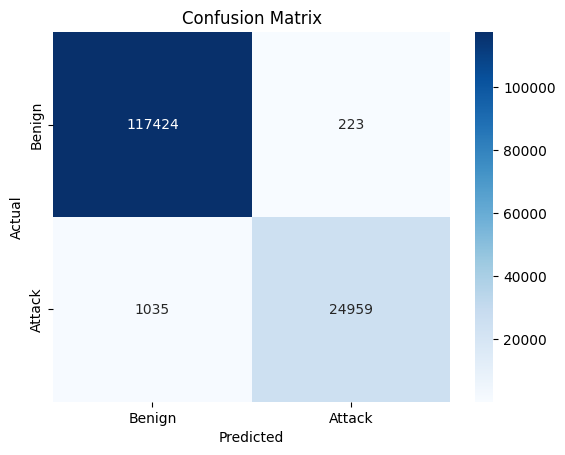

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_detailed(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    return all_preds, all_labels


preds, labels = evaluate_detailed(model, val_loader)


print(classification_report(labels, preds, target_names=["Benign", "Attack"]))


cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()